In [1]:
pip install pygame


Note: you may need to restart the kernel to use updated packages.


# Walkthrough: Basic neuroevolution

In this walkthrough we demonstrate how to evolve weights of a simple MLP neural network. The problem that we will use to demonstrate this is a Python implementation of the legendary mobile game Flappy bird.

<img src="flappyBird.jpg" alt="Flappy Bird" width=450>

# Defining a simple neural network

<img src="MLP.jpg" alt="MLP" width=400>

There are packages out there dedicated to producing neural networks, such as Tensorflow and Pytorch. However, for simplicity we will implement our own basic MLP, fully-connected and hard-coded with two hidden layers. For simplicity, I've also only added a single bias to the first hidden layer, but normally you'd have these for each layer.

Let's start by defining a class for our network:

In [2]:
import numpy as np
import math

class MLP(object):
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node from input to hidden layer 1 only
        self.numHidden1 = numHidden1 # Feel free to adapt the code to add more biases if you wish
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput) 
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1) 
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans

First we define the feedforward function of our network. To do this, we simply take the dot product of the input array and the weights from that input to the next layer of nodes. We then run those weighted sums through the ReLU function in the hidden layer, and the sigmoid in the last layer. This makes it similar to a non-linear regression problem.

In [3]:
class MLP(MLP):
    def feedForward(self, inputs):
        inputsBias = inputs[:]
        inputsBias.insert(len(inputs),1)             # Add bias input

        h1 = np.dot(self.w_i_h1, inputsBias)         # feed input to hidden layer 1
        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1
        
        h2 = np.dot(self.w_h1_h2, h1)                 # feed layer 1 to hidden layer 2
        h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)             # feed to output layer
        output = [self.sigmoid(x) for x in output]   # Activate output layer
        return output

Next we define functions that allow the genetic algorithm to get and set the weights as a simple one-dimensional list. This means we can then just work with the built-in operators without having to worry about defining our own to work with multidimensional arrays.

In [4]:
class MLP(MLP):
    
    def getWeightsLinear(self):
        flat_w_i_h1 = list(self.w_i_h1.flatten())
        flat_w_h1_h2 = list(self.w_h1_h2.flatten())
        flat_w_h2_o = list(self.w_h2_o.flatten())
        return( flat_w_i_h1 + flat_w_h1_h2 + flat_w_h2_o )

    def setWeightsLinear(self, Wgenome):
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * self.numHidden1
        numWeights_H2_O = self.numOutput * self.numHidden2

        self.w_i_h1 = np.array(Wgenome[:numWeights_I_H1])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))
        
        self.w_h1_h2 = np.array(Wgenome[numWeights_I_H1:(numWeights_H1_H2+numWeights_I_H1)])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        self.w_h2_o = np.array(Wgenome[(numWeights_H1_H2+numWeights_I_H1):])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

We will create a multi-layer perceptron with 3 inputs, 3 hidden nodes in hidden layer 1, and 2 in hidden layer 2, and 1 output. 

In [5]:
myNet = MLP(3,3,2,1)

Let's run a test on it.

In [6]:
a = myNet.getWeightsLinear()

In [7]:
a

[-0.010882357560797364,
 -0.2945273526823423,
 0.32047509726255546,
 0.5112630146648344,
 0.20366842177175834,
 0.8206119195344065,
 -0.5140532857548272,
 0.521069139315531,
 -0.9502971123835844,
 -1.4760123385065531,
 -0.05026650694956588,
 -0.9800224576468937,
 0.9157551448972665,
 1.1327535597501373,
 -0.5303206654492961,
 0.4596375893788705,
 1.314096124122693,
 0.9865225455644179,
 -0.09082731291099118,
 -0.6821454067017636]

It takes in a list of size 3 (inputs), and gives a list as output, with each element in the list being the output nodes (here we only have 1).

In [8]:
inputs = [0.5, 1.3, 0.1]

In [9]:
outcome = myNet.feedForward(inputs)

The outcome will be between 0 and 1, due to the sigmoid function. To make this binary we can add a step function as with binary regression.

In [10]:
print(outcome)

[0.15464635824751344]


In [11]:
int(outcome[0] > 0.5)

0

# The game

In [12]:
import pygame

pygame 2.5.2 (SDL 2.28.3, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


The PyGame library is a cross-platform set of Python modules utilized to develop video games. PyGame mainly comprises computer graphics and sound libraries designed to be utilized with the Python programming language.

In [13]:
class FlappyBird:
    def __init__(self):
        self.screen = pygame.display.set_mode((400, 708))
        self.bird = pygame.Rect(65, 50, 50, 50)
        self.background = pygame.image.load("assets/background.png").convert()
        self.birdSprites = [pygame.image.load("assets/1.png").convert_alpha(),
                            pygame.image.load("assets/2.png").convert_alpha(),
                            pygame.image.load("assets/dead.png")]
        self.wallUp = pygame.image.load("assets/bottom.png").convert_alpha()
        self.wallDown = pygame.image.load("assets/top.png").convert_alpha()
        self.gap = 130
        self.gravity = 5
        self.delay = False
        self.restart()

    def updateWalls(self):
        self.wallx -= 5
        self.distanceMoved += 5
        if self.wallx < -80:
            self.wallx = 400
            self.counter += 1
            self.offset = np.random.randint(-180, 200)

    def birdUpdate(self):
        if self.jump:
            self.jumpSpeed -= 1
            self.birdY -= self.jumpSpeed
            self.jump -= 1
        else:
            self.birdY += self.gravity
            self.gravity += 0.2
        self.bird[1] = self.birdY
        upRect = pygame.Rect(self.wallx,
                             360 + self.gap - self.offset + 10,
                             self.wallUp.get_width() - 10,
                             self.wallUp.get_height())
        downRect = pygame.Rect(self.wallx,
                               0 - self.gap - self.offset - 10,
                               self.wallDown.get_width() - 10,
                               self.wallDown.get_height())

        if upRect.colliderect(self.bird):
            self.dead = True
        if downRect.colliderect(self.bird):
            self.dead = True

        if not 0 < self.bird[1] < 720:
            self.dead = True

    def updateScreen(self):
        font = pygame.font.SysFont("Arial", 50)
        self.screen.fill((255, 255, 255))
        self.screen.blit(self.background, (0, 0))
        self.wallUpY = 360 + self.gap - self.offset
        self.wallDownY = 0 - self.gap - self.offset
        self.screen.blit(self.wallUp, (self.wallx, self.wallUpY))
        self.screen.blit(self.wallDown, (self.wallx, self.wallDownY))
        self.screen.blit(font.render(str(self.counter), -1, (255, 255, 255)),(200, 50))
        self.screen.blit(self.birdSprites[self.sprite], (70, self.birdY))

    def makeJump(self):
        self.jump = 17
        self.gravity = 5
        self.jumpSpeed = 10

    def restart(self):
        self.wallx = 400
        self.wallUpY = 0
        self.wallDownY = 0
        self.birdY = 400
        self.jump = 0 # A timer for the jump
        self.jumpSpeed = 10
        self.dead = False
        self.sprite = 1
        self.distanceMoved = 0
        self.counter = 0
        self.stepsSinceLastJump = 0
        self.offset = np.random.randint(-180, 300)

    def run(self, network):
        pygame.font.init()

        while self.dead == False:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    sys.exit()
                if (event.type == pygame.KEYDOWN) and not self.dead:
                    #self.makeJump()
                    if self.delay:
                        self.delay = False
                    else:
                        self.delay = True

            if self.delay: time.sleep(0.01)
                    
            # We don't want it going on forever, so set an upper limit
            if self.counter == 10:
                self.dead = True

            self.xdiff = 70 - self.wallx
            ydiffUp = self.birdY - self.wallUpY
            ydiffDown = self.birdY - self.wallDownY
            decision = network.feedForward([self.xdiff, ydiffUp, ydiffDown])

            if decision[0] > 0.5 and not self.dead:
                self.makeJump()

            self.updateScreen()
            self.updateWalls()
            self.birdUpdate()
            
            pygame.display.update()

        return self.distanceMoved

# The Genetic Algorithm

One approach could be to create a population of neural networks. However, that might be slow (and involve using copy.deepcopy) and not allow you to use DEAP's built in operators. Instead, we will evolve a population of flat lists, representing the neural network weights. We will only need to instantiate a single neural network to evaluate the fitness of those weights.

In [14]:
from deap import base
from deap import creator
from deap import tools

import random
import time

In [15]:
numInputNodes = 3
numHiddenNodes1 = 3
numHiddenNodes2 = 2
numOutputNodes = 1

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) + (numHiddenNodes1 * numHiddenNodes2) + (numHiddenNodes2 * numOutputNodes)

We now create a single neural network controller that we will use. We will evolve weights and pass them to this network when we need to evaluate their fitness.

In [16]:
myNet = MLP(numInputNodes, numHiddenNodes1, numHiddenNodes2, numOutputNodes)

In [17]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

In [18]:
def evaluate(indiv, myNet, game):
    myNet.setWeightsLinear(indiv)   # Load the individual's weights into the neural network
    game.restart()
    fitness = game.run(myNet) # Evaluate the individual by running the game (discuss)
    return fitness,

In [19]:
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.1)

In [20]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [21]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [22]:
logbook = tools.Logbook()

pop = toolbox.population(n=100)

We create a single game object. We will use this single object evaluate each of our solutions.

In [23]:
game = FlappyBird()

FileNotFoundError: No file 'assets/background.png' found in working directory '/Users/katiemaison/Documents/Repositories/evac-content/Week-5'.

In [ ]:
fitnesses = [toolbox.evaluate(indiv, myNet, game) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [ ]:
NGEN = 20

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet, game) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --


# Quick examination of the algorithm

In [ ]:
logbook.header = "gen", "avg", "evals", "std", "min", "max"

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
gen = logbook.select("gen")
avgs = logbook.select("avg")
stds = logbook.select("std")

Text(0, 0.5, 'Mean Fitness')

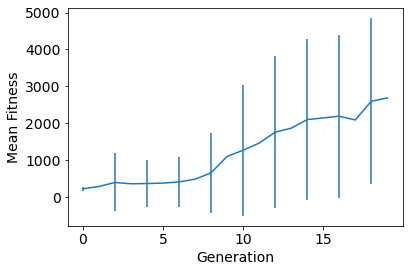

In [ ]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
#line1 = ax1.plot(gen, avgs)
line1 = ax1.errorbar(gen, avgs, yerr=stds, errorevery=2)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Mean Fitness")

# Examine the best solution

In [ ]:
indiv1 = tools.selBest(pop, 1)[0]
toolbox.evaluate(indiv1, myNet, game)

(4855,)

# Points to think about

1. The game has some element of chance, depending on how the random generator provides the level. In some games the variation due to chance/luck will be much greater. Where can we alter the code to account for this?
2. Could you alter the code to turn connections on and off (a limited way of evolving the topology)?
3. We have represented individuals as lists of weights. We have also not used crossover. This is because of the potential competing conventions problem with crossover.